# California House Prices
数据特点：
前半年用于train data, 后半年前半部分用于public test，后半部分用于Kaggle private test. (以后学习时序性数据的处理可以加上时序影响)
https://www.kaggle.com/competitions/california-house-prices/overview

12345

数据分析：
- id: the house ID
- Address: all valid
- Sold Price
- Summary: text description, *drop
- Type: SingleFamily, Condo, and other
- Year built:
- Heating: Central, [null], other
- cooling:Central Air, None, other
- Parking: Garage-Attached, (Garage,Garage - Attached, Covered), Other
- Lot: 占地面积
- Bedrooms:3, 4, other
- Bathrooms
- Full bathrooms
- Total interior livable area
- Total spaces
- Garage spaces
- Region
- Elementary School
- Elementary School Score
- Elementary School Distance
- Middle School
- Middle School Score
- Middle School Distance
- High School
- High School Score
- High School Distance
- Flooring
- Heating features
- Cooling features
- Appliances included
- Laundry features
- Parking features
- Tax assessed value
- Annual tax amount
- listed On: 挂牌时间
- listed Price:挂牌价格，跟实际成交价格相差不是太远，是强信号。
- last Sold On
- last Sold Price
- City
- Zip
- State

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.shape, test_data.shape

((47439, 41), (31626, 40))

In [4]:
# remove id and sold price fields
train_data_features = train_data.drop('Sold Price', axis=1)
all_features = pd.concat((train_data_features.iloc[:, 1:], test_data.iloc[:, 1:]))
all_features.shape

(79065, 39)

In [5]:
columns_to_drop = ['Address', 'Summary', 'Heating', 'Cooling', 'Parking', 'Elementary School', 'Middle School', 'High School', 'City', 'Listed On', 'Last Sold On', 'Zip']
all_features_drop = all_features.drop(columns_to_drop, axis=1)
all_features_drop.shape

(79065, 27)

In [ ]:
#如何对于极度右偏的数据进行绘制图形
all_features['Tax assessed value'].replace([np.inf, -np.inf], np.nan, inplace=True)
all_features['Tax assessed value'].fillna(0)
#all_features['Elementary School Distance'].dropna()
cleaned_lot_data = all_features['Tax assessed value']
# 对数据应用分位数裁剪
q_low = cleaned_lot_data.quantile(0.01)
q_high = cleaned_lot_data.quantile(0.99)
filtered_data = cleaned_lot_data[(cleaned_lot_data > q_low) & (cleaned_lot_data < q_high)]
plt.hist(filtered_data, bins=50, edgecolor='black')
plt.show()

数据中很多列都是因为极端值导致明显右偏？即使log transformation仍旧没法让其均匀分布
- 需要进行log变换的数据有Lot, total interior liveable area, Elementary School Distance, Middle School Distance, High School Distance, Tax assessed value, Annual tax amount, Listed Price, Last Sold Price
- year built 有异常值（<1000, ==9999），将其转换成nan
- Total spaces, garage spaces有异常负值，强制转换成nan。
- 因为Bedroom中含有description(string),不能够进行数据标准化

`np.log1p` 是 NumPy 库中的一个函数，它用于计算 1 加上一个数值后的自然对数，即 log(1 + x)。这个函数对于小数值非常有用，因为当 x 接近于零时，直接计算 log(1 + x) 可能会因为数值精度问题而不准确。
在统计学和机器学习中，np.log1p 经常用于**处理右偏分布**（当大部分数据聚集在较小的数值区间，但也有一些非常大的数值时）。使用 np.log1p 可以帮助稳定大数值，减少数据的偏斜度，并使其更适合于各种统计模型和机器学习模型。
`pd.to_numeric`: 这样会将 all_features_drop DataFrame 中的 'Bedrooms' 列转换为数值类型，如果有任何无法转换为数字的值（比如字符串），它们会被强制设置为 NaN。

In [1]:
stats = all_features_drop.describe()
stats

NameError: name 'all_features_drop' is not defined

In [6]:
#replace null, <1000, 9999 value in the Year built with nan.
all_features_drop.loc[(all_features_drop['Year built'] < 1000) | (all_features_drop['Year built'] == 9999), 'Year built'] = np.nan
#bedrooms混合数据类型
all_features_drop['Bedrooms'] = pd.to_numeric(all_features_drop['Bedrooms'], errors='coerce')
#Total space, garage space < 0 to nan
all_features_drop.loc[all_features['Total spaces'] < 0, 'Total spaces'] = np.nan
all_features_drop.loc[all_features['Garage spaces'] < 0, 'Garage spaces'] = np.nan

In [7]:
numeric_features_right_skewed = ['Lot', 'Total interior livable area', 'Total spaces', 'Garage spaces', 'Elementary School Distance', 'Middle School Distance', 'High School Distance', 'Tax assessed value', 'Annual tax amount', 'Last Sold Price']
all_features_drop[numeric_features_right_skewed].apply(np.log1p)
all_features_drop[numeric_features_right_skewed] = all_features_drop[numeric_features_right_skewed].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features_drop[numeric_features_right_skewed] = all_features_drop[numeric_features_right_skewed].fillna(0)

In [8]:
numeric_features = ['Year built', 'Bedrooms', 'Bathrooms', 'Full bathrooms', 'Elementary School Score', 'Middle School Score', 'High School Score', 'Listed Price']
all_features_drop[numeric_features] = all_features_drop[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features_drop[numeric_features] = all_features_drop[numeric_features].fillna(0)

In [ ]:
stats = all_features_drop.describe()
stats

如果使用 `df.join` 导致行数翻倍，这通常是因为要连接的 DataFrame（在您的例子中是 one_hot_encoded_state）的索引与 all_features DataFrame 的索引在某些行上不对齐。join 默认进行的是左连接，如果 one_hot_encoded_state 中的索引与 all_features 中的索引不完全匹配，那么 join 会尝试保留 all_features 中的所有行，并对于每个不匹配的索引添加新行，因此会导致行数增加。要解决这个问题，您需要确保在进行 join 操作前两个 DataFrame 有相同的索引。

In [9]:
#判断单列是否有多个数据类型，返回numpy.float64可能存在null值
def check_mixed_types(df, column_name):
    types = df[column_name].apply(type).unique()
    return types

types_in_column = check_mixed_types(all_features_drop, 'Last Sold Price')
print(types_in_column)

[<class 'float'>]


In [10]:
def check_mixed_types(df):
    # 创建一个字典来保存每列的数据类型
    column_types = {}
    for column in df.columns:
        # 获取每列的数据类型
        types = df[column].apply(type).unique()
        # 将结果存储在字典中
        column_types[column] = types
    return column_types

#判断单列是否有多个数据类型，返回numpy.float64可能存在null值
mixed_types = check_mixed_types(all_features_drop)
for column, types in mixed_types.items():
    print(f"Column: {column}, Types: {types}")

Column: Type, Types: [<class 'str'>]
Column: Year built, Types: [<class 'float'>]
Column: Lot, Types: [<class 'float'>]
Column: Bedrooms, Types: [<class 'float'>]
Column: Bathrooms, Types: [<class 'float'>]
Column: Full bathrooms, Types: [<class 'float'>]
Column: Total interior livable area, Types: [<class 'float'>]
Column: Total spaces, Types: [<class 'float'>]
Column: Garage spaces, Types: [<class 'float'>]
Column: Region, Types: [<class 'str'> <class 'float'>]
Column: Elementary School Score, Types: [<class 'float'>]
Column: Elementary School Distance, Types: [<class 'float'>]
Column: Middle School Score, Types: [<class 'float'>]
Column: Middle School Distance, Types: [<class 'float'>]
Column: High School Score, Types: [<class 'float'>]
Column: High School Distance, Types: [<class 'float'>]
Column: Flooring, Types: [<class 'str'> <class 'float'>]
Column: Heating features, Types: [<class 'str'> <class 'float'>]
Column: Cooling features, Types: [<class 'str'> <class 'float'>]
Column: 

In [11]:
#state有一个异常数字，需要强制将其转换成nan
all_features_drop['State'] = all_features_drop['State'].apply(lambda x: x if isinstance(x, str) else np.nan)
one_hot_encoded_state = pd.get_dummies(all_features_drop['State'], dummy_na=True)
#如果使用df.join行数会翻倍，请思考原因
all_features_state = pd.concat([all_features_drop.drop('State', axis=1), one_hot_encoded_state], axis=1)
all_features_state.shape

(79065, 29)

`.apply(set)`: 最后，apply 函数对上一步得到的字符串列表应用 set 函数，将列表转换成集合。集合是一个不包含重复元素的无序集合，这意味着如果原字符串中有重复的房屋类型描述（经过分割后），它们将被合并成一个。
这两行代码是使用 `sklearn`（scikit-learn库）的 `MultiLabelBinarizer` 类对房屋类型数据进行独热编码的步骤。
1. `mlb = MultiLabelBinarizer()`: 这一行创建了 `MultiLabelBinarizer` 的一个实例，并将其赋值给变量 `mlb`。`MultiLabelBinarizer` 是一个预处理类，用于将包含多标签的数据转换成独热编码（One-Hot Encoding）的形式。多标签数据是指数据的每个样本可以同时拥有多个标签，例如一个房屋可以同时被分类为 "Condo" 和 "Townhouse"。
2. `one_hot_encoded_house_type = mlb.fit_transform(all_features['HouseType'])`: 这一行调用 `mlb` 实例的 `fit_transform` 方法，将 `all_features` 数据框中的 `HouseType` 列转换为独热编码的形式。`fit_transform` 方法实际上执行了两个操作：
    - `fit`：确定数据中所有的不同标签，并为每个标签建立索引。
    - `transform`：将每个样本的标签转换为一个独热编码的向量，向量的长度等于所有不同标签的数量，向量中的每个元素对应一个标签，如果样本具有该标签，则对应位置为1，否则为0。
这两行代码的结果 `one_hot_encoded_house_type` 将是一个NumPy数组，其中每一行对应 `all_features['HouseType']` 中的一个样本，每一列对应一个可能的标签，如果原始数据中的集合包含某个标签，则该列的值为1，否则为0。

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

def encode_object_column(df, column_name):
    # 复制DataFrame以避免修改原始数据
    df = df.copy()
    # 处理列，将非字符串替换为空列表，字符串则分割
    df[column_name] = df[column_name].apply(lambda x: x.replace(' ', '').split(',') if isinstance(x, str) else [])  
    mlb = MultiLabelBinarizer()  
    # 对列进行独热编码，忽略NaN（空列表）
    one_hot_encoded = mlb.fit_transform(df[column_name])
    # 将独热编码结果转换为DataFrame
    one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)  
    df.drop(column_name, axis=1, inplace=True)
    # 合并原始DataFrame和独热编码DataFrame
    # 重置索引以确保无重复
    df.reset_index(drop=True, inplace=True)
    one_hot_encoded_df.reset_index(drop=True, inplace=True)
    df = pd.concat([df, one_hot_encoded_df], axis=1)
    return df

# 应用函数到DataFrame
all_features_type = encode_object_column(all_features_state, 'Type')
all_features_type.shape

(79065, 115)

In [13]:
all_features_floor = encode_object_column(all_features_type, 'Flooring')
all_features_floor.shape

(79065, 208)

In [14]:
all_features_heat = encode_object_column(all_features_floor, 'Heating features')
all_features_heat.shape

(79065, 289)

In [15]:
all_features_cool = encode_object_column(all_features_heat, 'Cooling features')
all_features_cool.shape

(79065, 369)

In [16]:
all_features_appliances = encode_object_column(all_features_cool, 'Appliances included')
all_features_appliances.shape

(79065, 463)

In [17]:
all_features_laundry = encode_object_column(all_features_appliances, 'Laundry features')
all_features_laundry.shape

(79065, 618)

In [18]:
all_features_park = encode_object_column(all_features_laundry, 'Parking features')
all_features_park.shape

(79065, 779)

In [19]:
all_features_region = encode_object_column(all_features_park, 'Region')
all_features_region.shape

(79065, 2036)

In [20]:
assert (train_data['Sold Price'] > 0).all()
if np.isnan(all_features_region.values).any():
    print("NaN values found in features!")

In [23]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features_region[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features_region[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data['Sold Price'].values.reshape(-1, 1), dtype=torch.float32
)  
train_features.shape, test_features.shape, train_labels.shape

(torch.Size([47439, 2036]), torch.Size([31626, 2036]), torch.Size([47439, 1]))

In [24]:
loss = nn.MSELoss()
num_inputs = train_features.shape[1]

net = nn.Sequential(
    nn.Linear(num_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLu(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1))

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [25]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, 
          learning_rate, weigt_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer=torch.optim.Adam(net.parameters(),
                               lr = learning_rate,
                               weight_decay=weigt_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [26]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):                                 #注意下面调用时包含在for i in range(k)外循环内
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [27]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]                 #每次分割后最后一次epoch返回的loss进行累加
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.316479, 验证log rmse0.329560
折2，训练log rmse0.318040, 验证log rmse0.316000
折3，训练log rmse0.319807, 验证log rmse0.302260
折4，训练log rmse0.300042, 验证log rmse0.315751
折5，训练log rmse0.291025, 验证log rmse0.339584
5-折验证: 平均训练log rmse: 0.309078, 平均验证log rmse: 0.320631


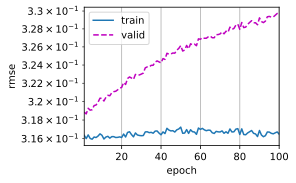

In [32]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.001, 0.009, 1000
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

训练log rmse：0.298213


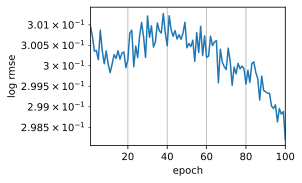

In [33]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    #test_features, test_labels设置为None, 因为没有test labels
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()             
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    submission.to_csv('submission.csv', index=False)
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [ ]:
n_train = train_data.shape[0]
n_valid = 10000
train_features = torch.tensor(all_features_region[:(n_train-n_valid)].values, dtype=torch.float32)
valid_features = torch.tensor(all_features_region[(n_train-n_valid):n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features_region[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data['Sold Price'][:(n_train-n_valid)].values.reshape(-1, 1), dtype=torch.float32
)
valid_labels = torch.tensor(
    train_data['Sold Price'][(n_train-n_valid):n_train].values.reshape(-1, 1), dtype=torch.float32)
    
train_features.shape, valid_features.shape, test_features.shape, train_labels.shape, valid_labels.shape

In [ ]:
def train(net, train_features, train_labels, valid_features, valid_labels, num_epochs, learning_rate, weigt_decay, batch_size):
    train_ls, valid_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    if valid_labels is not None: 
        valid_iter = d2l.load_array((valid_features, valid_labels), batch_size)
    optimizer=torch.optim.Adam(net.parameters(),
                               lr = learning_rate,
                               weight_decay=weigt_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if valid_labels is not None:
            valid_ls.append(log_rmse(net, valid_features, valid_labels))
        if epoch==0 or (epoch+1)%10 == 0:
            print(f'epoch{epoch + 1}，train log rmse:{float(train_ls[-1]):f}, '
                  f'valid log rmse:{float(valid_ls[-1]):f}')
    if valid_labels is not None:       
        d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        

In [ ]:
num_epochs, lr, weight_decay, batch_size = 50, 0.006, 0.0001, 1000
train(net, train_features, train_labels, valid_features, valid_labels, num_epochs, lr, weight_decay, batch_size)

In [ ]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    #test_features, test_labels设置为None, 因为没有test labels
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    
    # 预测测试集
    net.eval()  # 设置为评估模式
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    
    # 创建提交文件
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

1. 是否所有的数值型数据都需要进行标准化？对于那些极度右偏的数据log transformation后仍旧右偏怎么办？对于那些极值应该怎么处理？
2. 对于Bedrooms列这种数据类型混合（既有数值型又有string）应该怎么处理？我只是粗暴的直接drop,是否需要手动核实并且填充数据？
3. 对于zipcodes怎么处理？
4. 对于listed On and Last Sold On这样的日期怎么处理？
5. log rmse为大量的nan，应该怎么进行处理？
A:这通常发生在模型的预测中有些值不是有效的数字（NaN 或无穷），或者在计算损失时使用了不恰当的值。在您的情况中，这可能是由于几个原因：
数据预处理：确保所有的输入特征都已正确处理，并且没有包含无效值（如 NaN）。
标签的处理：torch.log(labels) 在 labels 包含 0 或负数时会产生 NaN。确保所有的 labels 值都是大于 0 的，因为对 0 或负数取对数是未定义的。
模型的预测：torch.clamp(net(features), 1, float('inf')) 确保了预测值至少为 1，以避免在取对数时出现 NaN。但如果模型预测出了非常大的值，那么对数可能会超出 float 类型的范围，导致无穷大或 NaN。
学习率和权重衰减：过高的学习率或不适当的权重衰减可能导致模型参数更新过猛，从而产生数值不稳定。
初始化问题：模型权重的初始值可能过大或过小，导致激活函数输出数值不稳定。
针对这些可能的问题，我们可以采取以下几步来调试和修正代码：
解决方法：
验证标签值：确保所有 train_labels 和 valid_labels 都是正数。
调整模型参数初始化：使用适当的初始化策略，例如 He 初始化或 Xavier 初始化。
检查输入特征：确保没有无效值，特别是在转换 all_features_region 为张量之后。（这里出现了问题）
使用更小的学习率：尝试一个更小的学习率来开始训练。
调整权重衰减：权重衰减太高可能导致模型参数快速衰减到 0，从而影响模型的学习过程。